In [29]:
import os
from pathlib import Path
import numpy as np
import pandas as pd
import cv2
from PIL import Image
import pytesseract
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, Dataset
import torchvision.transforms as transforms
import torchvision.models as models
from sklearn.metrics import confusion_matrix, classification_report
import seaborn as sns
import matplotlib.pyplot as plt
from tqdm import tqdm
import random
import joblib

DATA_OCR = r"C:\Guvi\Talent Intelligence & Workforce Optimization\data\document_ocr"
OUTPUT_TEXT = "output/ocr_text"
MODELS_DIR = "models"

Path(OUTPUT_TEXT).mkdir(parents=True, exist_ok=True)
Path(MODELS_DIR).mkdir(parents=True, exist_ok=True)

DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
DEVICE


device(type='cpu')

In [39]:
pytesseract.pytesseract.tesseract_cmd = r"C:\Program Files\Tesseract-OCR\tesseract.exe"


In [30]:
def preprocess_for_ocr(img):
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    gray = cv2.medianBlur(gray, 3)
    th = cv2.adaptiveThreshold(gray, 255,
                               cv2.ADAPTIVE_THRESH_GAUSSIAN_C,
                               cv2.THRESH_BINARY, 31, 12)
    return th

def ocr_extract(img_path):
    img = cv2.imread(img_path)
    if img is None:
        return ""
    proc = preprocess_for_ocr(img)
    pil_img = Image.fromarray(proc)
    text = pytesseract.image_to_string(pil_img)
    return text


In [31]:
class DocumentDataset(Dataset):
    def __init__(self, root_dir, transform=None, ignore_folders=["test"]):
        self.root_dir = Path(root_dir)
        self.transform = transform
        self.samples = []

        subfolders = []
        for d in self.root_dir.iterdir():
            if d.is_dir() and d.name not in ignore_folders:
                subfolders.append(d)

        print("Detected classes:", [d.name for d in subfolders])

        for c in subfolders:
            for img in c.rglob("*.*"):
                if img.suffix.lower() in [".png", ".jpg", ".jpeg"]:
                    self.samples.append((str(img), c.name))

        labels = sorted(list({label for _, label in self.samples}))
        self.label2idx = {label: i for i, label in enumerate(labels)}
        self.idx2label = {i: label for label, i in self.label2idx.items()}

        random.shuffle(self.samples)

    def __len__(self):
        return len(self.samples)

    def __getitem__(self, idx):
        path, label = self.samples[idx]
        img = Image.open(path).convert("RGB")
        if self.transform:
            img = self.transform(img)
        return img, self.label2idx[label]


In [32]:
train_transforms = transforms.Compose([
    transforms.Resize((300, 300)),
    transforms.RandomResizedCrop(256, scale=(0.6, 1.0)),
    transforms.RandomRotation(10),
    transforms.ColorJitter(brightness=0.4, contrast=0.4, saturation=0.3),
    transforms.RandomHorizontalFlip(),
    transforms.RandomVerticalFlip(),
    transforms.ToTensor(),
])

val_transforms = transforms.Compose([
    transforms.Resize((300, 300)),
    transforms.CenterCrop(256),
    transforms.ToTensor(),
])


In [33]:
dataset = DocumentDataset(DATA_OCR)

val_ratio = 0.2
n_val = int(len(dataset) * val_ratio)
n_train = len(dataset) - n_val

train_set, val_set = torch.utils.data.random_split(dataset, [n_train, n_val])

train_set.dataset.transform = train_transforms
val_set.dataset.transform = val_transforms

train_loader = DataLoader(train_set, batch_size=16, shuffle=True)
val_loader = DataLoader(val_set, batch_size=16, shuffle=False)

len(train_set), len(val_set)


Detected classes: ['document', 'form', 'invoice', 'real_life']


(3412, 853)

In [34]:
def build_model(num_classes):
    model = models.resnet50(weights="IMAGENET1K_V2")
    model.fc = nn.Linear(model.fc.in_features, num_classes)
    return model.to(DEVICE)

num_classes = len(dataset.label2idx)
model = build_model(num_classes)

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=1e-4)

scheduler = optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=10)


In [35]:
def train_one_epoch():
    model.train()
    total_loss, correct = 0, 0

    for imgs, labels in train_loader:
        imgs, labels = imgs.to(DEVICE), labels.to(DEVICE)

        optimizer.zero_grad()
        outputs = model(imgs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        total_loss += loss.item() * imgs.size(0)
        correct += (outputs.argmax(1) == labels).sum().item()

    return total_loss / len(train_set), correct / len(train_set)


def validate():
    model.eval()
    total_loss, correct = 0, 0

    with torch.no_grad():
        for imgs, labels in val_loader:
            imgs, labels = imgs.to(DEVICE), labels.to(DEVICE)
            outputs = model(imgs)
            loss = criterion(outputs, labels)

            total_loss += loss.item() * imgs.size(0)
            correct += (outputs.argmax(1) == labels).sum().item()

    return total_loss / len(val_set), correct / len(val_set)


In [36]:
EPOCHS = 4
best_acc = 0

for epoch in range(EPOCHS):
    train_loss, train_acc = train_one_epoch()
    val_loss, val_acc = validate()
    scheduler.step()

    print(f"Epoch {epoch+1}/{EPOCHS} | "
          f"Train Acc: {train_acc:.3f} | Val Acc: {val_acc:.3f}")

    if val_acc > best_acc:
        best_acc = val_acc
        torch.save(model.state_dict(), f"{MODELS_DIR}/document_classifier_high_acc.pth")
        print("✓ Improved — model saved.")


Epoch 1/4 | Train Acc: 0.973 | Val Acc: 0.999
✓ Improved — model saved.
Epoch 2/4 | Train Acc: 0.996 | Val Acc: 1.000
✓ Improved — model saved.
Epoch 3/4 | Train Acc: 1.000 | Val Acc: 1.000
Epoch 4/4 | Train Acc: 0.999 | Val Acc: 0.999


              precision    recall  f1-score   support

    document       1.00      1.00      1.00       314
        form       1.00      1.00      1.00        39
     invoice       1.00      1.00      1.00       203
   real_life       1.00      1.00      1.00       297

    accuracy                           1.00       853
   macro avg       1.00      1.00      1.00       853
weighted avg       1.00      1.00      1.00       853



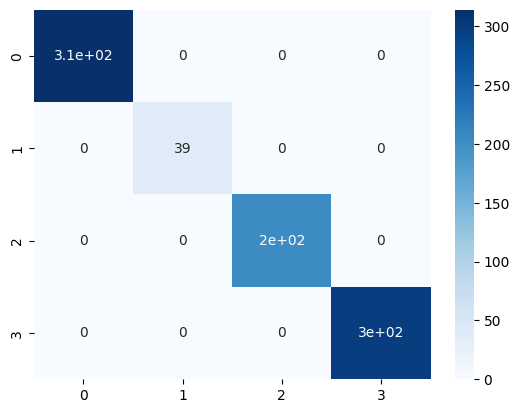

In [40]:
model.load_state_dict(torch.load(f"{MODELS_DIR}/document_classifier_high_acc.pth"))
model.eval()

all_preds, all_labels = [], []

with torch.no_grad():
    for imgs, labels in val_loader:
        imgs = imgs.to(DEVICE)
        preds = model(imgs).argmax(1).cpu().numpy()

        all_preds.extend(preds)
        all_labels.extend(labels.numpy())

cm = confusion_matrix(all_labels, all_preds)

print(classification_report(
    all_labels,
    all_preds,
    target_names=list(dataset.label2idx.keys())
))

sns.heatmap(cm, annot=True, cmap="Blues")
plt.show()


In [41]:
def classify_document(path):
    model.eval()
    img = Image.open(path).convert("RGB")
    img = val_transforms(img).unsqueeze(0).to(DEVICE)

    with torch.no_grad():
        pred = model(img).argmax(1).item()

    label = dataset.idx2label[pred]
    ocr_text = ocr_extract(path)
    return label, ocr_text[:300]

test_img = next(Path(DATA_OCR).rglob("*.jpg"))
label, text = classify_document(str(test_img))

print("Predicted class:", label)
print("\nOCR Text Snippet:\n", text)


Predicted class: invoice

OCR Text Snippet:
 tan woon yann

TXDAH GIFT & HCE BECO
27,JALEN DELAP 13,
TAKAN JOHCR JAYA,

91109 JOHOR PAHRJ, JOKER.
Tel:07-3507495 Fax:97-:

RECEIPT
19/19/2019 29:47:59 BOL
Cashiers CH Location/S?: 05 C521
HE: NG26SE8
Koos No: Of 950190025279
Desc/Itoa Qty _ Price Antik}
ST-PRIVILECE CARD/GE INGAH
aga3e ' 10.00 19
